# Post impression regression

## Notebooks set-up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

## 1. Data loading

In [2]:
# Load the post dataset
data_df = pd.read_csv('../public/data/01-raw_posts.csv')

# Inspect
data_df.head()

,impressions,post_url,post_text,word_count,n_tags,external_link,media,post_date
0,26,https://www.linkedin.com/posts/activity-736461...,Friday slide day! What to know from weeks 1 an...,38,7,False,True,2025-08-22
1,2389,https://www.linkedin.com/posts/activity-736427...,Has anyone tried marimo yet? Sounds great Pyth...,77,2,True,True,2025-08-21
2,43,https://www.linkedin.com/posts/activity-736389...,Large object promisors are comming to Git. Exc...,54,4,True,True,2025-08-20
3,50,https://www.linkedin.com/posts/activity-736355...,New paper by Chengshuai Zhao et al. Arizona St...,167,3,True,False,2025-08-19
4,40,https://www.linkedin.com/posts/activity-736318...,Nice blog post by Deane Barker - I love writin...,56,1,True,True,2025-08-18


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   impressions    89 non-null     int64 
 1   post_url       89 non-null     object
 2   post_text      89 non-null     object
 3   word_count     89 non-null     int64 
 4   n_tags         89 non-null     int64 
 5   external_link  89 non-null     bool  
 6   media          89 non-null     bool  
 7   post_date      89 non-null     object
dtypes: bool(2), int64(3), object(3)
memory usage: 4.5+ KB


## 2. Preprocessing

In [4]:
data_df.drop(['post_url', 'post_text'], axis=1, inplace=True)

In [5]:
post_datetime = pd.to_datetime(data_df['post_date'])
data_df['post_day'] = post_datetime.dt.day_name()
data_df.drop(['post_date'], axis=1, inplace=True)
data_df.head()

,impressions,word_count,n_tags,external_link,media,post_day
0,26,38,7,False,True,Friday
1,2389,77,2,True,True,Thursday
2,43,54,4,True,True,Wednesday
3,50,167,3,True,False,Tuesday
4,40,56,1,True,True,Monday


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   impressions    89 non-null     int64 
 1   word_count     89 non-null     int64 
 2   n_tags         89 non-null     int64 
 3   external_link  89 non-null     bool  
 4   media          89 non-null     bool  
 5   post_day       89 non-null     object
dtypes: bool(2), int64(3), object(1)
memory usage: 3.1+ KB


In [7]:
data_df.to_csv('../public/data/02-cleaned_posts.csv', index=False)

## 2. EDA
### 2.1. Feature distributions
#### 2.1.1. Categorical features

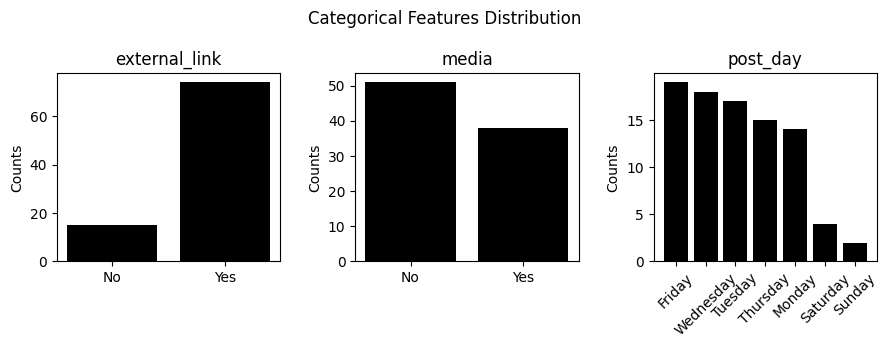

In [8]:
categorical_features = ['external_link', 'media', 'post_day']

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))

fig.suptitle('Categorical Features Distribution')

for i, categorical_feature in enumerate(categorical_features):

    axs[i].bar(
        data_df[categorical_feature].value_counts().index,
        data_df[categorical_feature].value_counts().values,
        color='black'
    )

    if categorical_feature != 'post_day':
        axs[i].set_xticks([0, 1])
        axs[i].set_xticklabels(['No', 'Yes'])

    if categorical_feature == 'post_day':
        axs[i].set_xticks(range(len(data_df[categorical_feature].value_counts())))
        axs[i].set_xticklabels(data_df[categorical_feature].value_counts().index, rotation=45)

    axs[i].set_title(categorical_feature)
    axs[i].set_ylabel('Counts')

fig.tight_layout()
fig.show()

#### 2.1.2. Numerical features

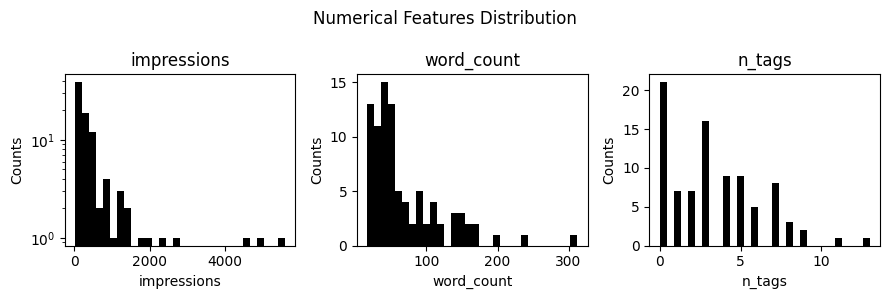

In [9]:
numerical_features = ['impressions', 'word_count', 'n_tags']

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

fig.suptitle('Numerical Features Distribution')

for i, numerical_feature in enumerate(numerical_features):
    axs[i].hist(data_df[numerical_feature], bins=30, color='black')
    axs[i].set_title(numerical_feature)
    axs[i].set_xlabel(numerical_feature)
    axs[i].set_ylabel('Counts')

    if numerical_feature == 'impressions':
        axs[i].set_yscale('log')

fig.tight_layout()
fig.show()

### 2.2. Feature interactions

#### 2.2.1. Categorical-categorical

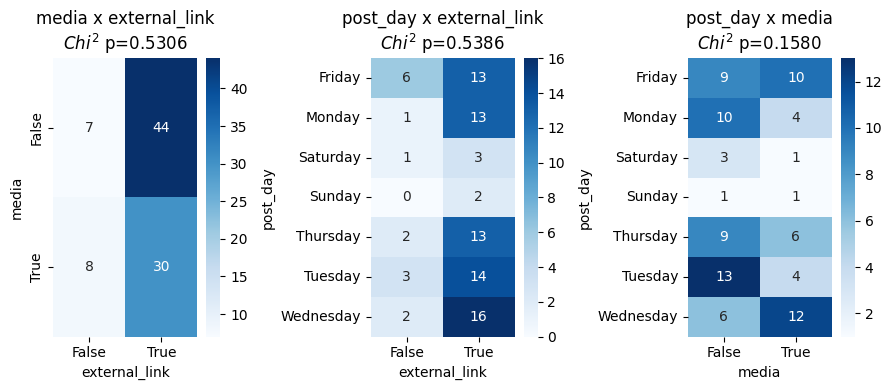

In [10]:
categorical_feature_pairs = [
    ['media', 'external_link'],
    ['post_day', 'external_link'],
    ['post_day', 'media']
]

fig, axs = plt.subplots(1, 3, figsize=(9, 4))

for i, feature_pair in enumerate(categorical_feature_pairs):

    contingency_table = pd.crosstab(data_df[feature_pair[0]], data_df[feature_pair[1]])
    chisquared_result = stats.chi2_contingency(contingency_table)

    axs[i].set_title(f'{feature_pair[0]} x {feature_pair[1]}\n$Chi^2$ p={chisquared_result[1]:.4f}')
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues', ax=axs[i])

fig.tight_layout()
fig.show()

#### 2.2.2. Numerical-categorical

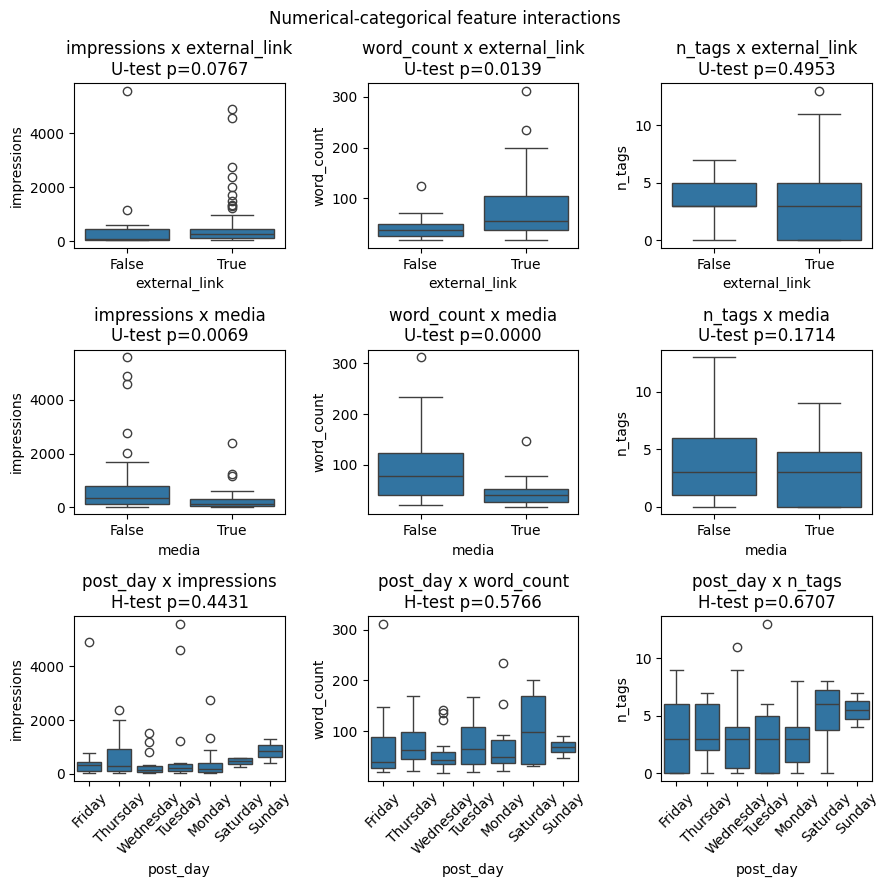

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

for i, categorical_feature in enumerate(categorical_features):

    fig.suptitle(f'Numerical-categorical feature interactions')

    for j, numerical_feature in enumerate(numerical_features):

        groups = [list(x) for _, x in data_df.dropna().groupby(data_df[categorical_feature])[numerical_feature]]

        if categorical_feature == 'post_day':
            result = stats.kruskal(*groups)
            axs[i,j].set_title(f'{categorical_feature} x {numerical_feature}\nH-test p={result.pvalue:.4f}')

        if categorical_feature != 'post_day':
            result = stats.mannwhitneyu(*groups)
            axs[i,j].set_title(f'{numerical_feature} x {categorical_feature}\nU-test p={result.pvalue:.4f}')

        sns.boxplot(data=data_df, x=categorical_feature, y=numerical_feature, ax=axs[i,j])

        if categorical_feature == 'post_day':
            axs[i,j].tick_params(axis='x', labelrotation=45)

    fig.tight_layout()
    fig.show()

#### 2.2.3. Numerical-numerical

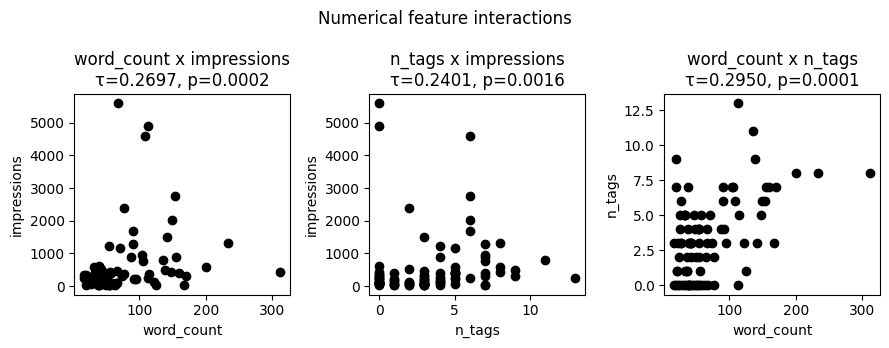

In [12]:
numerical_feature_pairs = [['word_count', 'impressions'], ['n_tags', 'impressions'], ['word_count', 'n_tags']]

fig, axs = plt.subplots(1, 3, figsize=(9, 3.5))

fig.suptitle('Numerical feature interactions')

for i, feature_pair in enumerate(numerical_feature_pairs):

    result = stats.kendalltau(data_df[feature_pair[0]], data_df[feature_pair[1]])
    axs[i].set_title(f'{feature_pair[0]} x {feature_pair[1]}\nτ={result.correlation:.4f}, p={result.pvalue:.4f}')

    axs[i].scatter(data_df[feature_pair[0]], data_df[feature_pair[1]], color='black')
    axs[i].set_xlabel(feature_pair[0])
    axs[i].set_ylabel(feature_pair[1])

fig.tight_layout()
fig.show()

## 3. Data preparation

In [13]:
features = ['n_tags', 'external_link', 'word_count', 'media', 'post_day']
label = 'impressions'

### 3.1. Label trimming

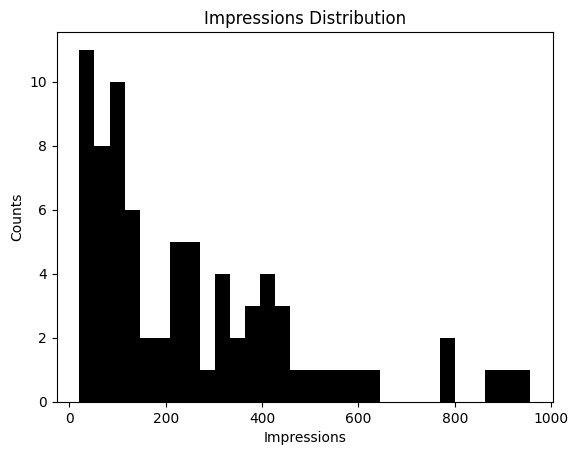

In [14]:
data_df = data_df[data_df['impressions'] < 1000]

plt.hist(data_df['impressions'], bins=30, color='black')
plt.title('Impressions Distribution')
plt.xlabel('Impressions')
plt.ylabel('Counts')
plt.show()

### 3.3. Feature trimming

In [15]:
# data_df = data_df[data_df['word_count'] < 200]

# plt.hist(data_df['word_count'], bins=30, color='black')
# plt.title('Word Count Distribution')
# plt.xlabel('Word Count')
# plt.ylabel('Counts')
# plt.show()

In [16]:
data_df = data_df[(data_df['post_day'] != 'Saturday') & (data_df['post_day'] != 'Sunday')]

### 3.5. Feature encoding

In [17]:
ordinal_encoder = OrdinalEncoder()
data_df[['media', 'external_link']] = ordinal_encoder.fit_transform(data_df[['media', 'external_link']])

days = {
    'Monday': '1',
    'Tuesday': '2',
    'Wednesday': '3',
    'Thursday': '4',
    'Friday': '5'
}

data_df['post_day'] = data_df['post_day'].map(days).astype(int)
data_df.head()

,impressions,word_count,n_tags,external_link,media,post_day
0,26,38,7,0.0,1.0,5
2,43,54,4,1.0,1.0,3
3,50,167,3,1.0,0.0,2
4,40,56,1,1.0,1.0,1
5,37,19,7,0.0,1.0,5


### 3.5. Feature scaling

In [18]:
data_df['word_count'] = np.log1p(data_df['word_count'])

scaler = StandardScaler()
data_df[features] = scaler.fit_transform(data_df[features])

In [19]:
data_df.head()

,impressions,word_count,n_tags,external_link,media,post_day
0,26,-0.423403,1.346978,-2.236068,1.087115,1.313221
2,43,0.127056,0.304156,0.447214,1.087115,-0.098002
3,50,1.915044,-0.043451,0.447214,-0.919866,-0.803613
4,40,0.184249,-0.738665,0.447214,1.087115,-1.509224
5,37,-1.492755,1.346978,-2.236068,1.087115,1.313221


In [20]:
data_df.describe()

,impressions,word_count,n_tags,external_link,media,post_day
count,72.000000,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01,7.200000e+01
mean,242.319444,-4.255855e-16,1.233581e-17,-1.418618e-16,1.973730e-16,3.083953e-17
std,224.284014,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00,1.007018e+00
min,21.000000,-1.661462e+00,-1.086272e+00,-2.236068e+00,-9.198662e-01,-1.509224e+00
25%,70.000000,-6.430946e-01,-8.255669e-01,4.472136e-01,-9.198662e-01,-8.036127e-01
50%,161.500000,-1.774425e-01,-4.345089e-02,4.472136e-01,-9.198662e-01,-9.800154e-02
75%,337.250000,5.060193e-01,6.517634e-01,4.472136e-01,1.087115e+00,7.840124e-01
max,957.000000,2.911395e+00,3.432620e+00,4.472136e-01,1.087115e+00,1.313221e+00


In [21]:
data_df.to_csv('../public/data/03-processed_posts.csv', index=False)

## 4. Linear regression

### 4.1. Single linear regression

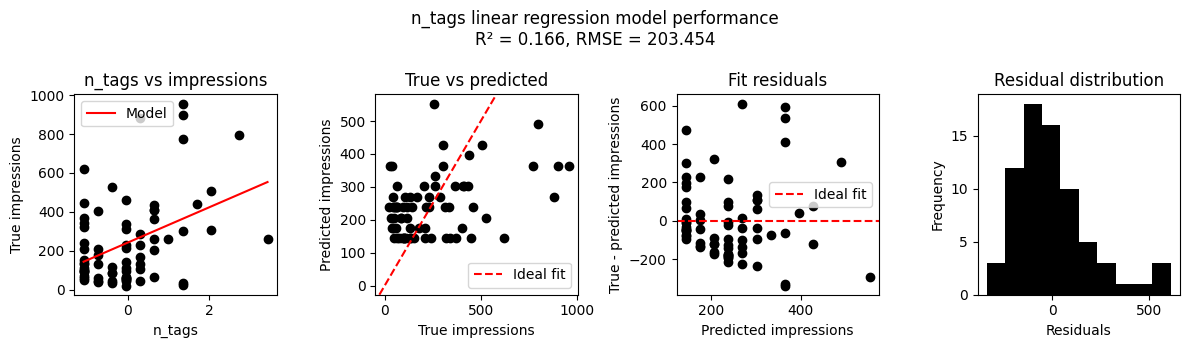

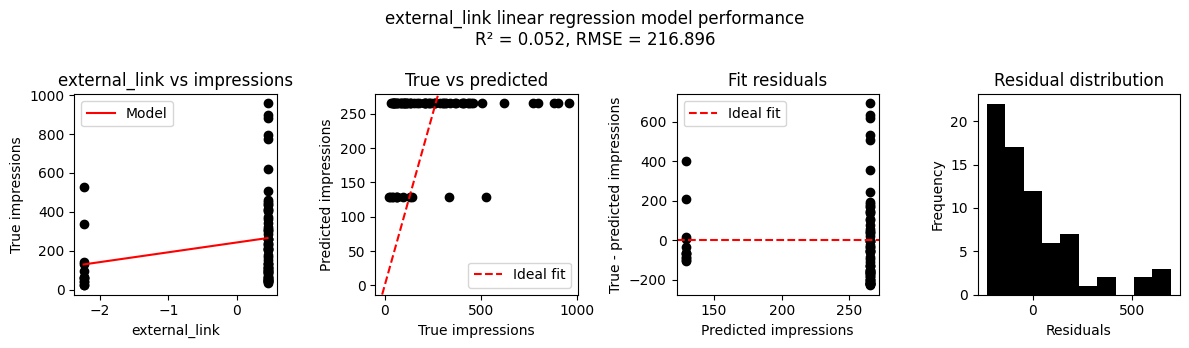

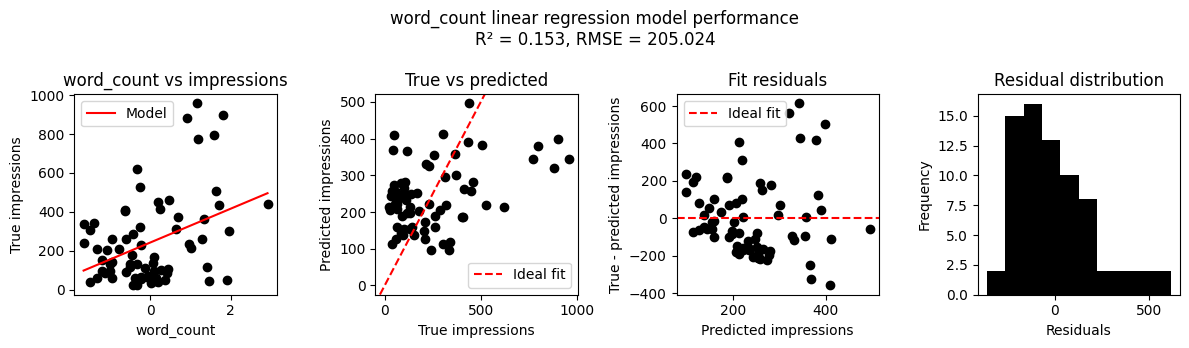

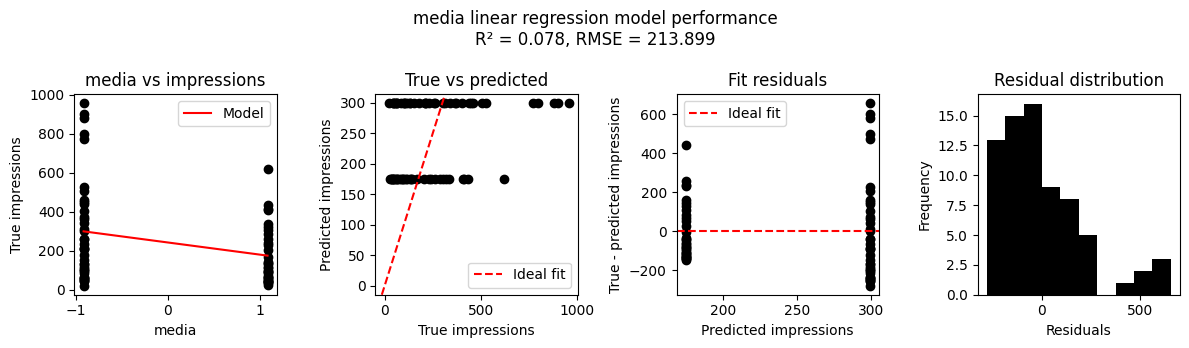

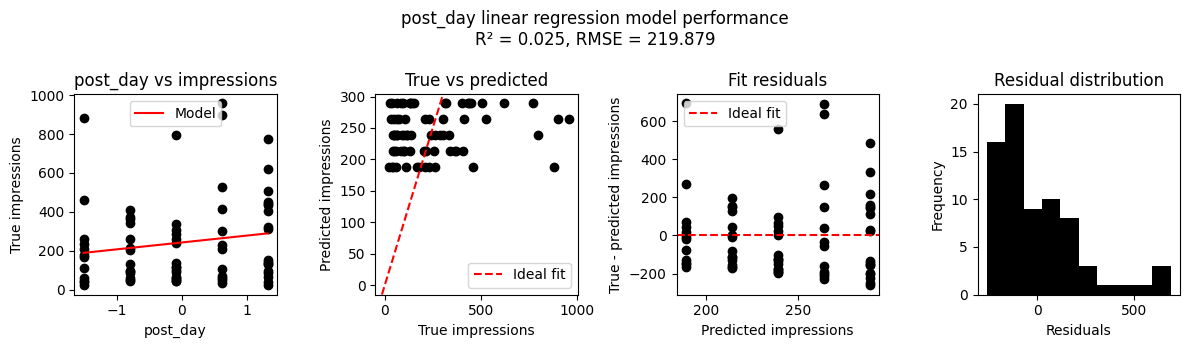

In [22]:
for feature in features:

    linear_model = LinearRegression()
    result = linear_model.fit(data_df[feature].to_frame(), data_df['impressions'])

    feature_values = data_df[feature]
    labels = data_df['impressions']
    predictions = linear_model.predict(data_df[feature].to_frame())

    predictions_df = pd.DataFrame({
        feature: feature_values,
        'labels': labels,
        'predictions': predictions
    })

    predictions_df.sort_values(by='predictions', inplace=True)

    residuals = labels - predictions
    standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
    residual_quantiles = np.percentile(standardized_residuals, [0, 25, 50, 75, 100])
    normal_quantiles = np.percentile(np.random.normal(size=1000), [0, 25, 50, 75, 100])

    rsq = r2_score(labels, predictions)
    rmse = root_mean_squared_error(labels, predictions)

    fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))

    fig.suptitle(f'{feature} linear regression model performance\nR\u00b2 = {rsq:.3f}, RMSE = {rmse:.3f}')

    axs[0].set_title(f'{feature} vs impressions')
    axs[0].scatter(data_df[feature], labels, color='black')
    axs[0].plot(predictions_df[feature], predictions_df['predictions'], color='red', label='Model')
    axs[0].set_xlabel(f'{feature}')
    axs[0].set_ylabel('True impressions')
    axs[0].legend(loc='best')

    axs[1].set_title('True vs predicted')
    axs[1].scatter(labels, predictions, color='black')
    axs[1].axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal fit')
    axs[1].set_xlabel('True impressions')
    axs[1].set_ylabel('Predicted impressions')
    axs[1].legend(loc='best')

    axs[2].set_title('Fit residuals')
    axs[2].scatter(predictions, residuals, color='black')
    axs[2].axhline(0, color='red', linestyle='--', label='Ideal fit')
    axs[2].set_xlabel('Predicted impressions')
    axs[2].set_ylabel('True - predicted impressions')
    axs[2].legend(loc='best')

    axs[3].set_title('Residual distribution')
    axs[3].hist(residuals, bins=10, color='black')
    axs[3].set_xlabel('Residuals')
    axs[3].set_ylabel('Frequency')

    fig.tight_layout()
    fig.show()

### 4.2. Multiple linear regression

R² = 0.324
RMSE = 183.060



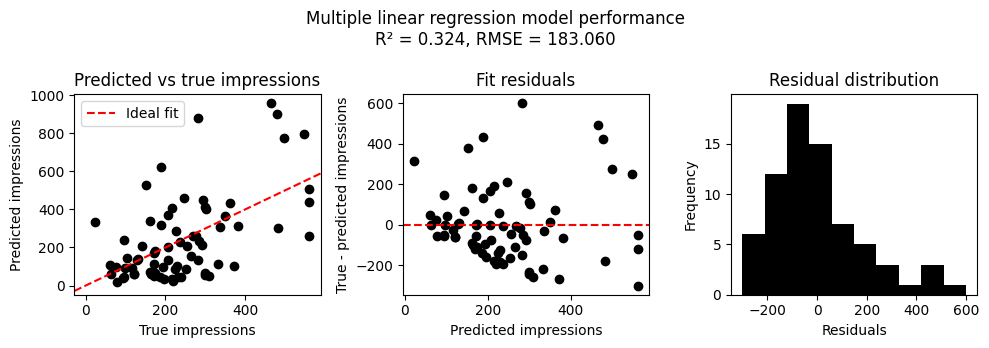

In [23]:
linear_model = LinearRegression()
result = linear_model.fit(data_df.drop('impressions', axis=1), data_df['impressions'])

predictions = linear_model.predict(data_df.drop('impressions', axis=1))
labels = data_df['impressions']
residuals = labels - predictions
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
residual_quantiles = np.percentile(standardized_residuals, [0, 25, 50, 75, 100])
normal_quantiles = np.percentile(np.random.normal(size=1000), [0, 25, 50, 75, 100])

rsq = r2_score(labels, predictions)
rmse = root_mean_squared_error(labels, predictions)

print(f'R\u00b2 = {rsq:.3f}')
print(f'RMSE = {rmse:.3f}\n')

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

fig.suptitle(f'Multiple linear regression model performance\nR\u00b2 = {rsq:.3f}, RMSE = {rmse:.3f}')

axs[0].set_title('Predicted vs true impressions')
axs[0].scatter(predictions, labels, color='black')
axs[0].axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[0].set_xlabel('True impressions')
axs[0].set_ylabel('Predicted impressions')
axs[0].legend(loc='best')

axs[1].set_title('Fit residuals')
axs[1].scatter(predictions, residuals, color='black')
axs[1].axhline(0, color='red', linestyle='--', label='Ideal fit')
axs[1].set_xlabel('Predicted impressions')
axs[1].set_ylabel('True - predicted impressions')

axs[2].set_title('Residual distribution')
axs[2].hist(residuals, bins=10, color='black')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

fig.tight_layout()
fig.show()


### 4.3. Feature importance

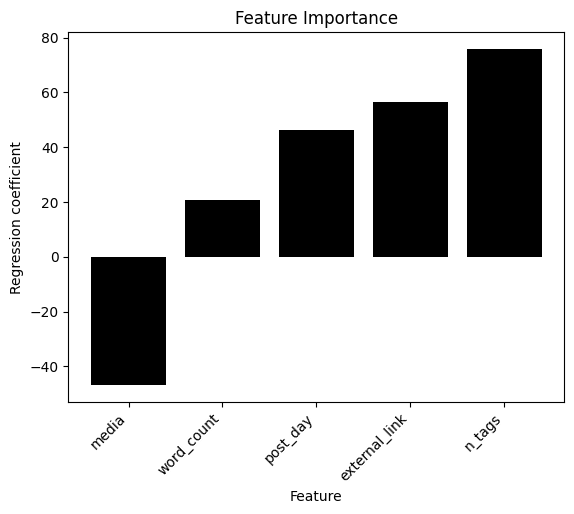

In [24]:
importance = pd.DataFrame({
    'Feature': data_df.drop('impressions', axis=1).columns,
    'Importance': linear_model.coef_
})

importance.sort_values(by='Importance', inplace=True)

plt.title('Feature Importance')
plt.bar(importance['Feature'], importance['Importance'], color='black')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Regression coefficient')
plt.show()

## 5. Model evaluation

In [25]:
train_df, test_df = train_test_split(data_df, test_size=0.5, random_state=3617)

linear_model = LinearRegression()
result = linear_model.fit(train_df.drop('impressions', axis=1), train_df['impressions'])

### 5.1. Training performance

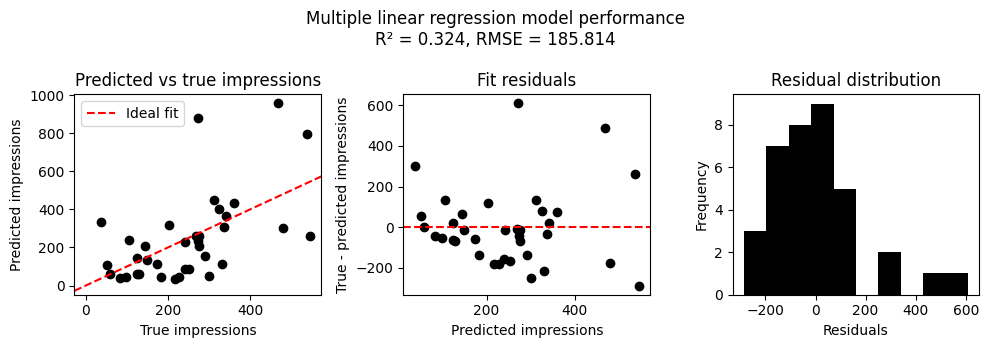

In [26]:
predictions = linear_model.predict(train_df.drop('impressions', axis=1))
labels = train_df['impressions']
residuals = labels - predictions
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
residual_quantiles = np.percentile(standardized_residuals, [0, 25, 50, 75, 100])
normal_quantiles = np.percentile(np.random.normal(size=1000), [0, 25, 50, 75, 100])

rsq = r2_score(labels, predictions)
rmse = root_mean_squared_error(labels, predictions)

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

fig.suptitle(f'Multiple linear regression model performance\nR\u00b2 = {rsq:.3f}, RMSE = {rmse:.3f}')

axs[0].set_title('Predicted vs true impressions')
axs[0].scatter(predictions, labels, color='black')
axs[0].axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[0].set_xlabel('True impressions')
axs[0].set_ylabel('Predicted impressions')
axs[0].legend(loc='best')

axs[1].set_title('Fit residuals')
axs[1].scatter(predictions, residuals, color='black')
axs[1].axhline(0, color='red', linestyle='--', label='Ideal fit')
axs[1].set_xlabel('Predicted impressions')
axs[1].set_ylabel('True - predicted impressions')

axs[2].set_title('Residual distribution')
axs[2].hist(residuals, bins=10, color='black')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

fig.tight_layout()
fig.show()

### 5.2. Testing performance

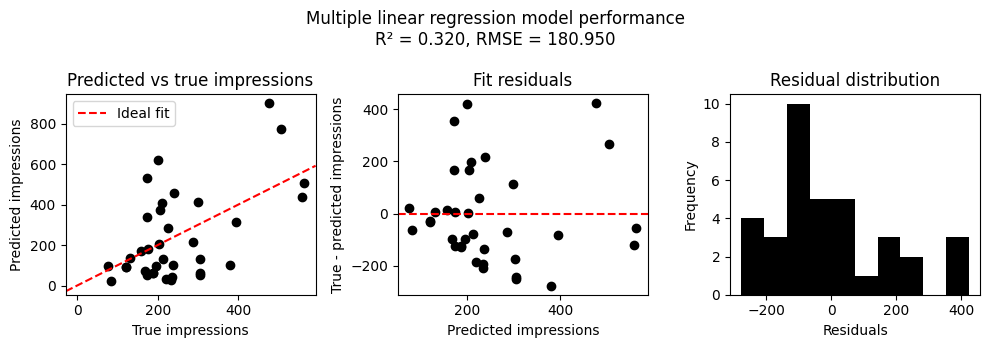

In [27]:
predictions = linear_model.predict(test_df.drop('impressions', axis=1))
labels = test_df['impressions']
residuals = labels - predictions
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
residual_quantiles = np.percentile(standardized_residuals, [0, 25, 50, 75, 100])
normal_quantiles = np.percentile(np.random.normal(size=1000), [0, 25, 50, 75, 100])

rsq = r2_score(labels, predictions)
rmse = root_mean_squared_error(labels, predictions)

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))

fig.suptitle(f'Multiple linear regression model performance\nR\u00b2 = {rsq:.3f}, RMSE = {rmse:.3f}')

axs[0].set_title('Predicted vs true impressions')
axs[0].scatter(predictions, labels, color='black')
axs[0].axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal fit')
axs[0].set_xlabel('True impressions')
axs[0].set_ylabel('Predicted impressions')
axs[0].legend(loc='best')

axs[1].set_title('Fit residuals')
axs[1].scatter(predictions, residuals, color='black')
axs[1].axhline(0, color='red', linestyle='--', label='Ideal fit')
axs[1].set_xlabel('Predicted impressions')
axs[1].set_ylabel('True - predicted impressions')

axs[2].set_title('Residual distribution')
axs[2].hist(residuals, bins=10, color='black')
axs[2].set_xlabel('Residuals')
axs[2].set_ylabel('Frequency')

fig.tight_layout()
fig.show()